In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tqdm import tqdm

# Dataset import and load class

In [ ]:
class Dataset():
    def __init__(self, file_path, batch_size, task='face'):
        self.image_file = [file_path +'/'+filename for filename in os.listdir(file_path)]
        self.batch_size = batch_size
        self.task = task
    def train_image(self, image_file):
        """
        train image load, 224x672 real_image, mask_image, binary_image 
        """
        # Read and decode an image file to a uint8 tensor
        image = tf.io.read_file(image_file)
        image = tf.io.decode_image(image, channels=3, expand_animations = False)
        
        w = tf.shape(image)[1]
        w = w // 3

        real_image = image[:, :w, :]
        mask_image = image[:, w:w+w, :]
        binary_image = image[:, w+w:, :]
        # binary_image = binary_image[:, :, 0]

        # Convert both images to float32 tensors
        real_image = tf.cast(real_image, tf.float32)
        mask_image = tf.cast(mask_image, tf.float32)
        binary_image = tf.cast(binary_image, tf.float32)
        
        return real_image, mask_image, binary_image


    def test_image(self, image_file):
        """
        test image load
        """
        # Read and decode an image file to a uint8 tensor
        image = tf.io.read_file(image_file)
        image = tf.io.decode_image(image, channels=3, expand_animations = False)

        input_image = image[:, :, :]

        # Convert both images to float32 tensors
        input_image = tf.cast(input_image, tf.float32)

        return input_image


    def train_resize_and_normalize(self, real_image, mask_image, binary_image, height, width, task):
        """
        image resize and [-1 ~ 1] normalize
        """
        
        real_image = tf.image.resize(real_image, [height, width],
                    method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        mask_image = tf.image.resize(mask_image, [height, width],
                                    method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        binary_image = tf.image.resize(binary_image, [height, width],
                        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        if task == "mask":
          real_image = real_image / 255.0
          mask_image = mask_image / 255.0
          binary_image = binary_image / 255.0

        elif task == "face":
          real_image = (real_image / 127.5) - 1
          mask_image = (mask_image / 127.5) - 1
          binary_image = (binary_image / 127.5) - 1
        
        return real_image, mask_image, binary_image

    def test_resize_and_normalize(self, mask_image, height, width):
        """
        image resize and [-1 ~ 1] normalize
        """
        input_image = tf.image.resize(mask_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        input_image = tf.cast(input_image, tf.float32)
        input_image = (input_image / 127.5) - 1
        return input_image


    def load_image_train(self, image_file):
        real_image, mask_image, binary_image = self.train_image(image_file)
        real_image, mask_image, binary_image = self.train_resize_and_normalize(real_image, mask_image, binary_image, 128, 128, task=self.task)
        
        return real_image, mask_image, binary_image

    def load_image_test(self, image_file):
        input_image = self.test_image(image_file)
        input_image = self.test_resize_and_normalize(input_image, 128, 128)

        return input_image  


    def make_train(self):
        dataset = tf.data.Dataset.list_files(self.image_file, shuffle=True, seed=42)
        dataset = dataset.map(self.load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.batch(self.batch_size)
        
        return dataset  
    
    def make_test(self):
        dataset = tf.data.Dataset.list_files(self.image_file, shuffle=False)
        dataset = dataset.map(self.load_image_test, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.batch(self.batch_size)
        
        return dataset  

# Batch instance normallization Layer


Ref : Batch Instance Normalization Layer (https://arxiv.org/abs/1805.07925).

In [ ]:
class BatchInstanceNormalization(tf.keras.layers.Layer):
    """Batch Instance Normalization Layer (https://arxiv.org/abs/1805.07925)."""

    def __init__(self, epsilon=1e-5):
        super(BatchInstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.rho = self.add_weight(
            name='rho',
            shape=input_shape[-1:],
            initializer='ones',
            constraint=lambda x: tf.clip_by_value(x, clip_value_min=0.0, clip_value_max=1.0),
            trainable=True)
    
        self.gamma = self.add_weight(
            name='gamma',
            shape=input_shape[-1:],
            initializer='ones',        
            trainable=True)
    
        self.beta = self.add_weight(
            name='beta',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
  
    def call(self, x):
        batch_mean, batch_sigma = tf.nn.moments(x, axes=[0, 1, 2], keepdims=True)
        x_batch = (x - batch_mean) * (tf.math.rsqrt(batch_sigma + self.epsilon))

        ins_mean, ins_sigma = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        x_ins = (x - ins_mean) * (tf.math.rsqrt(ins_sigma + self.epsilon))

        return (self.rho * x_batch + (1 - self.rho) * x_ins) * self.gamma + self.beta


# Mask Generator Model

In [ ]:
class Mask_G(tf.keras.Model):
  def __init__(self, filters=64, kernel_size=3, strides=1, padding='same'):
    super(Mask_G, self).__init__()

    initializer = tf.random_normal_initializer(0., 0.02)
    self.strides = strides
    self.kernel_size = kernel_size
    self.padding = padding

    self.conv1_1 = layers.Conv2D(filters, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.conv1_2 = layers.Conv2D(filters, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.bn1_2 = BatchInstanceNormalization()
    self.pool1 = layers.MaxPooling2D(pool_size=(2, 2))
    
    self.conv2_1 = layers.Conv2D(filters*2, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.bn2_1 = BatchInstanceNormalization()
    self.conv2_2 = layers.Conv2D(filters*2, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.bn2_2 = BatchInstanceNormalization()
    self.pool2 = layers.MaxPooling2D(pool_size=(2, 2))
    
    self.conv3_1 = layers.Conv2D(filters*4, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.bn3_1 = BatchInstanceNormalization()
    self.conv3_2 = layers.Conv2D(filters*4, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.bn3_2 = BatchInstanceNormalization()
    self.pool3 = layers.MaxPooling2D(pool_size=(2, 2))
    
    self.conv4_1 = layers.Conv2D(filters*8, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.bn4_1 = BatchInstanceNormalization()
    self.conv4_2 = layers.Conv2D(filters*8, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.bn4_2 = BatchInstanceNormalization()
    self.pool4 = layers.MaxPooling2D(pool_size=(2, 2))
    
    self.conv5_1 = layers.Conv2D(filters*8, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.bn5_1 = BatchInstanceNormalization()
    self.conv5_2 = layers.Conv2D(filters*8, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.bn5_2 = BatchInstanceNormalization()
        
    self.convt1 = layers.Conv2DTranspose(filters*8, kernel_size=self.kernel_size, strides=self.strides*2, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.conv6_1 = layers.Conv2D(filters*8, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.bn6_1 = BatchInstanceNormalization()
    self.conv6_2 = layers.Conv2D(filters*8, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.bn6_2 = BatchInstanceNormalization()
    
    self.convt2 = layers.Conv2DTranspose(filters*4, kernel_size=self.kernel_size, strides=self.strides*2, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.conv7_1 = layers.Conv2D(filters*4, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.bn7_1 = BatchInstanceNormalization()
    self.conv7_2 = layers.Conv2D(filters*4, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.bn7_2 = BatchInstanceNormalization()
    
    self.convt3 = layers.Conv2DTranspose(filters*2, kernel_size=self.kernel_size, strides=self.strides*2, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.conv8_1 = layers.Conv2D(filters*2, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.bn8_1 = BatchInstanceNormalization()
    self.conv8_2 = layers.Conv2D(filters*2, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.bn8_2 = BatchInstanceNormalization()
    
    self.convt4 = layers.Conv2DTranspose(filters*1, kernel_size=self.kernel_size, strides=self.strides*2, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.conv9_1 = layers.Conv2D(filters*1, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.bn9_1 = BatchInstanceNormalization()
    self.conv9_2 = layers.Conv2D(filters*1, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.bn9_2 = BatchInstanceNormalization()
    
    self.out = layers.Conv2D(1, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)

  def call(self, inputs, training=False):
    # encoder
    enc_1 = self.conv1_1(inputs)
    enc_1 = self.conv1_2(enc_1)
    enc_1 = self.bn1_2(enc_1, training=training)
    enc_1 = tf.nn.leaky_relu(enc_1)
    pool1 = self.pool1(enc_1)

    enc_2 = self.conv2_1(pool1)
    enc_2 = self.bn2_1(enc_2, training=training)
    enc_2 = tf.nn.leaky_relu(enc_2)
    enc_2 = self.conv2_2(enc_2)
    enc_2 = self.bn2_2(enc_2, training=training)
    enc_2 = tf.nn.leaky_relu(enc_2)
    pool2 = self.pool2(enc_2)

    enc_3 = self.conv3_1(pool2)
    enc_3 = self.bn3_1(enc_3, training=training)
    enc_3 = tf.nn.leaky_relu(enc_3)
    enc_3 = self.conv3_2(enc_3)
    enc_3 = self.bn3_2(enc_3, training=training)
    enc_3 = tf.nn.leaky_relu(enc_3)
    pool3 = self.pool3(enc_3)

    enc_4 = self.conv4_1(pool3)
    enc_4 = self.bn4_1(enc_4, training=training)
    enc_4 = tf.nn.leaky_relu(enc_4)
    enc_4 = self.conv4_2(enc_4)
    enc_4 = self.bn4_2(enc_4, training=training)
    enc_4 = tf.nn.leaky_relu(enc_4)
    pool4 = self.pool4(enc_4)

    brige = self.conv5_1(pool4)
    brige = self.bn5_1(brige, training=training)
    brige = tf.nn.leaky_relu(brige)
    brige = self.conv5_2(brige)
    brige = self.bn5_2(brige, training=training)
    brige = tf.nn.leaky_relu(brige)

    # decoder
    dec_4 = self.convt1(brige)
    cat4 = layers.Concatenate()([enc_4, dec_4])
    dec_4 = self.conv6_1(cat4)
    dec_4 = self.bn6_1(dec_4)
    dec_4 = tf.nn.leaky_relu(dec_4)
    dec_4 = self.conv6_2(dec_4)
    dec_4 = self.bn6_2(dec_4)
    dec_4 = tf.nn.leaky_relu(dec_4)
    
    
    dec_3 = self.convt2(dec_4)
    cat3 = layers.Concatenate()([enc_3, dec_3])
    dec_3 = self.conv7_1(cat3)
    dec_3 = self.bn7_1(dec_3)
    dec_3 = tf.nn.leaky_relu(dec_3)
    dec_3 = self.conv7_2(dec_3)
    dec_3 = self.bn7_2(dec_3)
    dec_3 = tf.nn.leaky_relu(dec_3)
    
    dec_2 = self.convt3(dec_3)
    cat2 = layers.Concatenate()([enc_2, dec_2])
    dec_2 = self.conv8_1(cat2)
    dec_2 = self.bn8_1(dec_2)
    dec_2 = tf.nn.leaky_relu(dec_2)
    dec_2 = self.conv8_2(dec_2)
    dec_2 = self.bn8_2(dec_2)
    dec_2 = tf.nn.leaky_relu(dec_2)
    
    dec_1 = self.convt4(dec_2)
    cat1 = layers.Concatenate()([enc_1, dec_1])
    dec_1 = self.conv9_1(cat1)
    dec_1 = self.bn9_1(dec_1)
    dec_1 = tf.nn.leaky_relu(dec_1)
    dec_1 = self.conv9_2(dec_1)
    dec_1 = self.bn9_2(dec_1)
    dec_1 = tf.nn.leaky_relu(dec_1)
    
    out = self.out(dec_1)

    return tf.keras.activations.tanh(out)

# Face generator model 

Used to get face from masked image

In [ ]:
class Face_G(tf.keras.Model):
  def __init__(self, filters=64, kernel_size=3, strides=1, padding='same'):
    super(Face_G, self).__init__()

    initializer = tf.random_normal_initializer(0., 0.02)
    self.strides = strides
    self.kernel_size = kernel_size
    self.padding = padding

    self.conv1_1 = layers.Conv2D(filters, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.conv1_2 = layers.Conv2D(filters, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.pool1 = layers.MaxPooling2D(pool_size=(2, 2))
    
    self.conv2_1 = layers.Conv2D(filters*2, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.bn2_1 = BatchInstanceNormalization()
    self.conv2_2 = layers.Conv2D(filters*2, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.bn2_2 = BatchInstanceNormalization()
    self.pool2 = layers.MaxPooling2D(pool_size=(2, 2))

    self.conv3_1 = layers.Conv2D(filters*4, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, dilation_rate=(2, 2), use_bias=False)
    self.bn3_1 = BatchInstanceNormalization()
    self.conv3_2 = layers.Conv2D(filters*4, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, dilation_rate=(4, 4), use_bias=False)
    self.bn3_2 = BatchInstanceNormalization()
    self.conv3_3 = layers.Conv2D(filters*4, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, dilation_rate=(8, 8), use_bias=False)
    self.bn3_3 = BatchInstanceNormalization()
    self.conv3_4 = layers.Conv2D(filters*4, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, dilation_rate=(16, 16), use_bias=False)
    self.bn3_4 = BatchInstanceNormalization()
        
    self.convt1 = layers.Conv2DTranspose(filters*2, kernel_size=self.kernel_size, strides=self.strides*2, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.conv6_1 = layers.Conv2D(filters*2, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.bn6_1 = BatchInstanceNormalization()
    self.conv6_2 = layers.Conv2D(filters*2, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.bn6_2 = BatchInstanceNormalization()
    
    self.convt2 = layers.Conv2DTranspose(filters*1, kernel_size=self.kernel_size, strides=self.strides*2, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.conv7_1 = layers.Conv2D(filters*1, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.bn7_1 = BatchInstanceNormalization()
    self.conv7_2 = layers.Conv2D(filters*1, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.bn7_2 = BatchInstanceNormalization()
    self.conv7_3 = layers.Conv2D(3, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    self.bn7_3 = BatchInstanceNormalization()
    
    self.out = layers.Conv2D(3, kernel_size=1, strides=self.strides, padding=self.padding, kernel_initializer=initializer, use_bias=False)
    
  def call(self, inputs, training=False):
    # encoder
    input_mask = inputs[0]
    input_map = inputs[1]
    input = layers.concatenate([input_mask, input_map])
    
    enc_1 = self.conv1_1(input)
    enc_1 = self.conv1_2(enc_1)
    enc_1 = tf.nn.leaky_relu(enc_1)
    pool1 = self.pool1(enc_1)

    enc_2 = self.conv2_1(pool1)
    enc_2 = self.bn2_1(enc_2, training=training)
    enc_2 = tf.nn.leaky_relu(enc_2)
    enc_2 = self.conv2_2(enc_2)
    enc_2 = self.bn2_2(enc_2, training=training)
    enc_2 = tf.nn.leaky_relu(enc_2)
    pool2 = self.pool2(enc_2)

    enc_3 = self.conv3_1(pool2)
    enc_3 = self.bn3_1(enc_3, training=training)
    enc_3 = tf.nn.leaky_relu(enc_3)
    enc_3 = self.conv3_2(enc_3)
    enc_3 = self.bn3_2(enc_3, training=training)
    enc_3 = tf.nn.leaky_relu(enc_3)
    enc_3 = self.conv3_3(enc_3)
    enc_3 = self.bn3_3(enc_3, training=training)
    enc_3 = tf.nn.leaky_relu(enc_3)
    enc_3 = self.conv3_4(enc_3)
    enc_3 = self.bn3_4(enc_3, training=training)
    enc_3 = tf.nn.leaky_relu(enc_3)

    # decoder
    dec_4 = self.convt1(enc_3)
    cat4 = layers.Concatenate()([enc_2, dec_4])
    dec_4 = self.conv6_1(cat4)
    dec_4 = self.bn6_1(dec_4)
    dec_4 = tf.nn.leaky_relu(dec_4)
    dec_4 = self.conv6_2(dec_4)
    dec_4 = self.bn6_2(dec_4)
    dec_4 = tf.nn.leaky_relu(dec_4)
    
    dec_3 = self.convt2(dec_4)
    cat3 = layers.Concatenate()([enc_1, dec_3])
    dec_3 = self.conv7_1(cat3)
    dec_3 = self.bn7_1(dec_3)
    dec_3 = tf.nn.leaky_relu(dec_3)
    dec_3 = self.conv7_2(dec_3)
    dec_3 = self.bn7_2(dec_3)
    dec_3 = tf.nn.leaky_relu(dec_3)
    dec_3 = self.conv7_3(dec_3)
    dec_3 = self.bn7_3(dec_3)
    dec_3 = tf.nn.leaky_relu(dec_3)

    out = self.out(dec_3)

    return tf.keras.activations.tanh(out)

# Whole face discriminator

Evaluates the whole face produced by the face genrator

In [ ]:
class Face_D_whole(tf.keras.Model):
    def __init__(self, filters=64, kernel_size=4, strides=1, padding='same'):
        super(Face_D_whole, self).__init__()

        initializer = tf.random_normal_initializer(0., 0.02)

        self.filters = filters
        self.strides = strides
        self.kernel_size = kernel_size
        self.padding = padding

        self.conv1_1 = layers.Conv2D(filters*1, kernel_size=self.kernel_size, strides=self.strides*2, padding=self.padding, kernel_initializer=initializer, use_bias=False)

        self.conv2_1 = layers.Conv2D(filters*2, kernel_size=self.kernel_size, strides=self.strides*2, padding=self.padding, kernel_initializer=initializer, use_bias=False)
        self.bn2_1 = BatchInstanceNormalization()

        self.conv3_1 = layers.Conv2D(filters*4, kernel_size=self.kernel_size, strides=self.strides*2, padding=self.padding, kernel_initializer=initializer, use_bias=False)
        self.bn3_1 = BatchInstanceNormalization()

        self.zero_pad1 = layers.ZeroPadding2D()
        self.conv4_1 = layers.Conv2D(filters*8, kernel_size=self.kernel_size, strides=self.strides, padding='valid', kernel_initializer=initializer, use_bias=False)
        self.bn4_1 = BatchInstanceNormalization()

        self.zero_pad2 = layers.ZeroPadding2D()
        self.conv5_1 = layers.Conv2D(1, kernel_size=self.kernel_size, strides=self.strides, padding='valid', kernel_initializer=initializer)

    def call(self, inputs, training=False):  

        x = self.conv1_1(inputs)
        x = tf.nn.leaky_relu(x)

        x = self.conv2_1(x)
        x = self.bn2_1(x)
        x = tf.nn.leaky_relu(x)

        x = self.conv3_1(x)
        x = self.bn3_1(x)
        x = tf.nn.leaky_relu(x)

        x = self.zero_pad1(x)
        x = self.conv4_1(x)
        x = self.bn4_1(x)
        x = tf.nn.leaky_relu(x)
        
        x = self.zero_pad2(x)
        x = self.conv5_1(x)
        return x

# Masked region discriminator model

Discriminator which assess the masked region genreated from Face generator. It uses region identified by the mask generator

In [ ]:
class Face_D_region(tf.keras.Model):
    def __init__(self, filters=64, kernel_size=4, strides=1, padding='same'):
        super(Face_D_region, self).__init__()

        initializer = tf.random_normal_initializer(0., 0.02)

        self.filters = filters
        self.strides = strides
        self.kernel_size = kernel_size
        self.padding = padding

        self.conv1_1 = layers.Conv2D(filters*1, kernel_size=self.kernel_size, strides=self.strides*2, padding=self.padding, kernel_initializer=initializer, use_bias=False)

        self.conv2_1 = layers.Conv2D(filters*2, kernel_size=self.kernel_size, strides=self.strides*2, padding=self.padding, kernel_initializer=initializer, use_bias=False)
        self.bn2_1 = BatchInstanceNormalization()

        self.conv3_1 = layers.Conv2D(filters*4, kernel_size=self.kernel_size, strides=self.strides*2, padding=self.padding, kernel_initializer=initializer, use_bias=False)
        self.bn3_1 = BatchInstanceNormalization()

        self.zero_pad1 = layers.ZeroPadding2D()
        self.conv4_1 = layers.Conv2D(filters*8, kernel_size=self.kernel_size, strides=self.strides, padding='valid', kernel_initializer=initializer, use_bias=False)
        self.bn4_1 = BatchInstanceNormalization()

        self.zero_pad2 = layers.ZeroPadding2D()
        self.conv5_1 = layers.Conv2D(1, kernel_size=self.kernel_size, strides=self.strides, padding='valid', kernel_initializer=initializer)

    def prepare_input_disc_mask(self, x):
        Igt_Iedit = x[0]
        Imask_map = x[1]
        Iinput = x[2]
        Imask_map = Imask_map/255.0
        complementary = 1-Imask_map
        firstmul = layers.Multiply()([Iinput, complementary])
        secondmul = layers.Multiply()([Igt_Iedit, Imask_map])
        Imask_region = layers.Add()([firstmul, secondmul])

        return Imask_region

    def call(self, inputs, training=False):  #input.shape : ([None, 128, 128, 3], [None, 128, 128, 1], [None, 128, 128, 3])
        Igt_Iedit = inputs[0] # Ground truth or generated image
        Imask_map = inputs[1] # Mask map image
        Iinput = inputs[2] # Original image
        input = layers.Lambda(self.prepare_input_disc_mask)([Igt_Iedit, Imask_map, Iinput]) # preparation input

        x = self.conv1_1(input)
        x = tf.nn.leaky_relu(x)

        x = self.conv2_1(x)
        x = self.bn2_1(x)
        x = tf.nn.leaky_relu(x)

        x = self.conv3_1(x)
        x = self.bn3_1(x)
        x = tf.nn.leaky_relu(x)

        x = self.zero_pad1(x)
        x = self.conv4_1(x)
        x = self.bn4_1(x)
        x = tf.nn.leaky_relu(x)
        
        x = self.zero_pad2(x)
        x = self.conv5_1(x)
        return x

# VGG model

Calculates the similarity between real image and generated image and improves the image. Using pretrained VGG model

In [ ]:
class VGG19_model():
  def __init__(self):
    selected_layers = ["block3_conv4", "block4_conv4", "block5_conv4"]
    self.vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
    self.vgg.trainable = False
    self.outputs = [self.vgg.get_layer(l).output for l in selected_layers]

  def get_vgg19(self):
    vgg_model = tf.keras.Model(self.vgg.input, self.outputs)
    return vgg_model

# Noise Processing

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

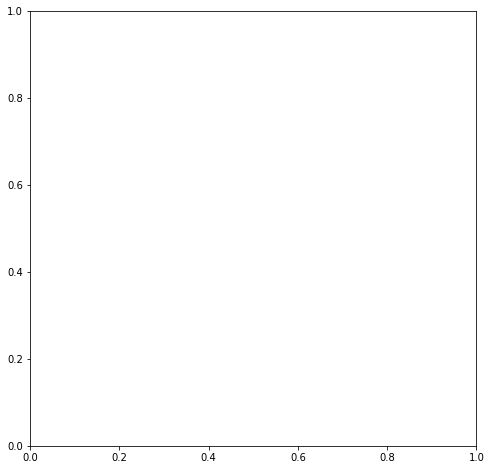

In [ ]:
plt.ion()
figure, ax = plt.subplots(figsize=(8,8))

np.random.seed(42)

In [ ]:
%%writefile noise_processing.py
def noise_processing(generate_image):

    generate_image = generate_image.numpy()
    batch, height, width  = generate_image.shape[0], generate_image.shape[1], generate_image.shape[2]
    generate_image = generate_image[:, :, :, 0]
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
    for i in range(batch):
        generate_image[i]= cv2.erode(generate_image[i], k)        
        generate_image[i] = cv2.dilate(generate_image[i], k)
    generate_image = np.where(generate_image >= -0.9, 1, -1)
    generate_image = tf.convert_to_tensor(generate_image, dtype=tf.float32)
    generate_image = tf.reshape(generate_image, [batch, height, width , 1])
    return generate_image

Writing noise_processing.py


In [ ]:
def mask_training_visualization(model, test_input, tar, epoch, step):

    
    save_dir = './mask32_training'
    if not os.path.exists(save_dir):
      os.mkdir(save_dir)  

    prediction = model(test_input, training=True)
    display_list = [test_input[0], tar[0], prediction[0, :, :, 0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        
    plt.savefig(save_dir+"/epoch_{epoch}_step_{step}.png".format(epoch=epoch+1, step=step+1))
    plt.show()
    
    figure.canvas.draw()
    figure.canvas.flush_events()

In [ ]:
def face_training_visualization(model, test_input, binary_input, tar, epoch, step):
    """
    fece model training visualization
    Args:
        model : Mask Generate model
        test_input : input image
        binary_input : Mask Generate model out
        tar : ground truth image
        epoch, step : training epoch, step
    """
    
    save_dir = './face32_training'
    if not os.path.exists(save_dir):
      os.mkdir(save_dir)  
      
    prediction = model([test_input, binary_input], training=False)
    print(prediction.shape)
    display_list = [test_input[0], tar[0], prediction[0, :, :, :]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.savefig(save_dir+"/epoch_{epoch}_step_{step}.png".format(epoch=epoch+1, step=step+1))
    plt.show()
    
    figure.canvas.draw()
    figure.canvas.flush_events()

# Predicting Functions

In [ ]:
import PIL

In [ ]:
class Load_model():
    def __init__(self, mask_model, face_model, mask_checkpoint_dir, face_checkpoint_dir):
        self.mask_model = mask_model
        self.face_model = face_model
        self.mask_model.build(input_shape=(None, 128, 128, 3))
        self.face_model.build(input_shape=[(None, 128, 128, 3), (None, 128, 128, 1)])  
        
        self.mask_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        self.face_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        
        self.mask_checkpoint_dir = mask_checkpoint_dir
        self.face_checkpoint_dir = face_checkpoint_dir

        self.mask_checkpoint = tf.train.Checkpoint(generator_optimizer=self.mask_optimizer,
                                            generator=self.mask_model)        
        self.face_checkpoint = tf.train.Checkpoint(generator_optimizer=self.face_optimizer,
                                            generator=self.face_model)
        
    def load(self):
        self.mask_checkpoint.restore(tf.train.latest_checkpoint(self.mask_checkpoint_dir))
        self.face_checkpoint.restore(tf.train.latest_checkpoint(self.face_checkpoint_dir))
    
    def one_predict(self, img_dir):        
        img = plt.imread(img_dir)
        if img_dir.endswith('.png'):
            img = img * 255.0
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = tf.image.resize(img, [128, 128],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        img = tf.reshape(img, [1, 128, 128, 3])
        img = tf.cast(img, tf.float32)
        img =  (img / 127.5) - 1
        
        mask = self.mask_model(img, training=False)
        #mask = noise_processing(mask)
        face = self.face_model([img, mask], training=False)

        plt.figure(figsize=(7,7))
        plt.subplot(1, 2, 1)
        plt.title('Image with mask')
        plt.imshow(img[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.title('Prediction Image')
        plt.imshow(face[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()
        tensor = face*255
        face = np.array(tensor, dtype=np.uint8)
        if np.ndim(face)>3:
          assert face.shape[0] == 1
          face = face[0]
        return PIL.Image.fromarray(face)
        
    def multiple_predict(self, img_dir):     
        testset = Dataset(file_path=img_dir, batch_size=1)
        testset = testset.make_test()
        img_num = len(testset)
        
        plt.figure(figsize=(10, 10))
        plt.suptitle('Prediction Image', fontsize=20, y=0.7)
        
        for i, img in enumerate(testset):
            mask = self.mask_model(img, training=False)
            process_img = noise_processing(img, mask)
            pred = self.face_model(process_img, training=False)
            pred = tf.concat([img, pred], axis=1)

            plt.subplot(1, img_num, i+1)
            plt.imshow(pred[0] * 0.5 + 0.5)
            plt.axis('off') 
        plt.show()

## Training the Model

In [ ]:
class Train_Mask:
    def __init__(self, model, alpha=100, lr=2e-4, checkpoint_dir=None):
        self.model = model
        self.model.build(input_shape=(None, 128, 128, 3))
        self.alpha = alpha
        self.lr = lr
        self.checkpoint_dir = checkpoint_dir
        self.bce_loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.optimizer = tf.keras.optimizers.Adam(self.lr, beta_1=0.5)
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.optimizer,
                                        generator=self.model)
        self.checkpoint.restore(tf.train.latest_checkpoint(self.checkpoint_dir))
        
    def generator_loss(self, gen_output, target):
        # Binary cross entropy
        bce_loss = self.bce_loss(target, gen_output)

        # l1_loss = self.alpha * tf.reduce_mean(tf.abs(target - gen_output))
        # total_gen_loss = gan_loss + (self.alpha * l1_loss)

        return bce_loss

    # @tf.function
    def train_step(self, input_image, target):
        with tf.GradientTape() as gen_tape:
            gen_output = self.model(input_image, training=True)
            gen_loss = self.generator_loss(gen_output, target)
        generator_gradients = gen_tape.gradient(gen_loss,
                                                self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(generator_gradients,
                                            self.model.trainable_variables))
        
        return gen_loss.numpy()
    
    def save(self, checkpoint_dir):
        if not os.path.exists(checkpoint_dir):
            os.mkdir(checkpoint_dir)
        self.checkpoint.save(file_prefix= self.checkpoint_prefix)

    def load(self, checkpoint_dir):
        self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
        
    def fit(self, dataset, epochs):     
        for epoch in range(epochs):
            pbar = tqdm(enumerate(dataset), total=len(dataset), desc='epoch', ncols=80)   
            pbar.set_description(f'{epoch+1} epoch')
            for step, (_, mask_input ,binary_input) in pbar:
                binary_input = np.where(binary_input >= 0.5, 1, 0)
                binary_input = tf.convert_to_tensor(binary_input, dtype=tf.float32)
                loss = self.train_step(mask_input, binary_input[:,:,:, 0])
                # and pbar loss update
                if step % 20 == 0:
                    pbar.set_postfix(loss=loss)    
                # training_visualization once per 500 step
                if step % 1000 == 0:
                    mask_training_visualization(self.model, mask_input, binary_input, epoch, step)     
            # Save (checkpoint) the model once per 2 epcoh
            if (epoch + 1) % 2 == 0:
                self.save(self.checkpoint_dir)

class Train_Face:
    def __init__(self, mask_model, face_model, dis_whole_model, dis_region_model, vgg19, lr=2e-4, mask_checkpoint_dir=None, face_checkpoint_dir=None, dis_checkpoint_dir=None):
        self.mask_model = mask_model
        self.face_model = face_model
        self.dis_whole_model = dis_whole_model
        self.dis_region_model = dis_region_model
        self.vgg19 = vgg19.get_vgg19()

        self.mask_model.build(input_shape=(None, 128, 128, 3))
        self.face_model.build(input_shape=[(None, 128, 128, 3), (None, 128, 128, 1)])  
        self.dis_whole_model.build(input_shape=(None, 128, 128, 3))
        self.dis_region_model.build(input_shape=[(None, 128, 128, 3), (None, 128, 128, 1), (None, 128, 128, 3)])

        self.LAMBDA_whole = 0.3
        self.LAMBDA_mask = 0.7
        self.LAMBDA_rc = 100

        self.lr = lr
        self.gan_BCE_loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)

        self.mask_optimizer = tf.keras.optimizers.Adam(self.lr, beta_1=0.5)
        self.face_optimizer = tf.keras.optimizers.Adam(self.lr, beta_1=0.5)
        self.dis_whole_optimizer = tf.keras.optimizers.Adam(self.lr, beta_1=0.5)
        self.dis_region_optimizer = tf.keras.optimizers.Adam(self.lr, beta_1=0.5)

        self.mask_checkpoint_dir = mask_checkpoint_dir
        self.face_checkpoint_dir = face_checkpoint_dir
        self.dis_checkpoint_dir = dis_checkpoint_dir

        self.face_checkpoint_prefix = os.path.join(self.face_checkpoint_dir, "ckpt")
        self.dis_checkpoint_prefix = os.path.join(self.dis_checkpoint_dir, "ckpt")
        
        self.mask_checkpoint = tf.train.Checkpoint(generator_optimizer=self.mask_optimizer,
                                generator=self.mask_model)
                
        self.face_checkpoint = tf.train.Checkpoint(generator_optimizer=self.face_optimizer,
                                                  generator=self.face_model)
        
        self.dis_checkpoint = tf.train.Checkpoint(dis_whole_optimizer=self.dis_whole_optimizer,
                                          dis_region_optimizer=self.dis_region_optimizer, 
                                          dis_whole=self.dis_whole_model,
                                          dis_region=self.dis_region_model)

        self.mask_checkpoint.restore(tf.train.latest_checkpoint(self.mask_checkpoint_dir))
        self.face_checkpoint.restore(tf.train.latest_checkpoint(self.face_checkpoint_dir))
        self.dis_checkpoint.restore(tf.train.latest_checkpoint(self.dis_checkpoint_dir))

    # @tf.function
    def perceptual_loss(self, gen_image, gt_image):
        h1_list = self.vgg19(gen_image)
        h2_list = self.vgg19(gt_image)
        perc_loss = 0.0
        for h1, h2 in zip(h1_list, h2_list):
            h1 = tf.reshape(h1, [h1.shape[0], -1])
            h2 = tf.reshape(h2, [h2.shape[0], -1])
            perc_loss += tf.math.reduce_sum(tf.math.square((h1 - h2)), axis=-1)
        perc_loss = tf.reduce_mean(perc_loss)
        return perc_loss

    def gen_loss(self, disc_gen_output):
        adv_loss = self.gan_BCE_loss(tf.ones_like(disc_gen_output), disc_gen_output) # Adversarial loss
        return adv_loss
        
    def rec_loss(self, gen_output, target):
        # ssim loss
        ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(gen_output, target, max_val=1.0))
        # Mean absolute error
        l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
        rec_loss = ssim_loss + l1_loss
        return rec_loss

    def disc_loss(self, disc_real_output, disc_gen_output):
        real_loss = self.gan_BCE_loss(tf.ones_like(disc_real_output), disc_real_output) # Real samples
        fake_loss = self.gan_BCE_loss(tf.zeros_like(disc_gen_output), disc_gen_output) # Fake samples
        total_loss = real_loss + fake_loss
        return total_loss

    # @tf.function
    def train_step_first(self, input_image, input_map, target):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_image = self.face_model([input_image, input_map], training=True)

            real_output = self.dis_whole_model(input_image, training=True)
            fake_output = self.dis_whole_model(generated_image, training=True)
        
            generator_loss = self.gen_loss(fake_output)
            discriminator_loss = self.disc_loss(real_output, fake_output)
            rc_loss = self.rec_loss(generated_image, target)
            perc_loss = self.perceptual_loss(generated_image, target)
            gen_tot_loss = self.LAMBDA_rc*(rc_loss + perc_loss) + generator_loss
        
        gradients_generator = gen_tape.gradient(gen_tot_loss,
                                            self.face_model.trainable_variables)
        gradients_disc_whole  = disc_tape.gradient(discriminator_loss,
                                            self.dis_whole_model.trainable_variables)
            
        self.face_optimizer.apply_gradients(zip(gradients_generator,
                                              self.face_model.trainable_variables))
        self.dis_whole_optimizer.apply_gradients(zip(gradients_disc_whole,
                                              self.dis_whole_model.trainable_variables))
        
        
        return gen_tot_loss.numpy(), discriminator_loss.numpy()


    # @tf.function
    def train_step_second(self, input_image, input_map, target):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_whole_tape, tf.GradientTape() as disc_mask_tape:
            generated_image = self.face_model([input_image, input_map], training=True)

            real_output_whole = self.dis_whole_model(input_image, training=True)
            fake_output_whole = self.dis_whole_model(generated_image, training=True)
            real_output_mask = self.dis_region_model([target, input_map, input_image], training=True)
            fake_output_mask = self.dis_region_model([generated_image, input_map, input_image], training=True)

            gen_loss_whole = self.gen_loss(fake_output_whole)
            disc_loss_whole = self.LAMBDA_whole * self.disc_loss(real_output_whole, fake_output_whole)
            gen_loss_mask = self.gen_loss(fake_output_mask)
            disc_loss_mask = self.LAMBDA_mask * self.disc_loss(real_output_mask, fake_output_mask)
            rc_loss = self.rec_loss(generated_image, target)
            perc_loss = self.perceptual_loss(generated_image, target)
            gen_tot_loss = self.LAMBDA_rc*(rc_loss + perc_loss) + self.LAMBDA_whole*(gen_loss_whole) + self.LAMBDA_mask*(gen_loss_mask)
        
        gradients_generator = gen_tape.gradient(gen_tot_loss, self.face_model.trainable_variables)
        gradients_disc_whole = disc_whole_tape.gradient(disc_loss_whole, self.dis_whole_model.trainable_variables)
        gradients_disc_mask = disc_mask_tape.gradient(disc_loss_mask, self.dis_region_model.trainable_variables)
            
        self.face_optimizer.apply_gradients(zip(gradients_generator,
                                              self.face_model.trainable_variables))
        self.dis_whole_optimizer.apply_gradients(zip(gradients_disc_whole,
                                              self.dis_whole_model.trainable_variables))
        self.dis_whole_optimizer.apply_gradients(zip(gradients_disc_mask,
                                      self.dis_region_model.trainable_variables))
        
        return gen_tot_loss.numpy(), disc_loss_whole.numpy(), disc_loss_mask.numpy()

    def save(self, face_checkpoint_dir, dis_checkpoint_dir):
        if not os.path.exists(face_checkpoint_dir):
            os.mkdir(face_checkpoint_dir)
        if not os.path.exists(dis_checkpoint_dir):
            os.mkdir(dis_checkpoint_dir)
        self.face_checkpoint.save(file_prefix= self.face_checkpoint_prefix)
        self.dis_checkpoint.save(file_prefix= self.dis_checkpoint_prefix)

    def load(self, face_checkpoint_dir, dis_checkpoint_dir):
        self.face_checkpoint.restore(tf.train.latest_checkpoint(face_checkpoint_dir))
        self.dis_checkpoint.restore(tf.train.latest_checkpoint(dis_checkpoint_dir))

    def fit(self, dataset, epochs):     
        ratio = int(round(epochs * 0.4))
        for epoch in range(epochs):
            pbar = tqdm(enumerate(dataset), total=len(dataset), desc='epoch', ncols=150)   
            pbar.set_description(f'{epoch+1} epoch')
            disc_region_loss = 0
            for step, (real_input, mask_input, binary_input) in pbar:
                if epoch < ratio:
                    gen_output = self.mask_model(mask_input, training=False)
                    binary_input = noise_processing(gen_output)
                    gen_tot_loss, disc_whole_loss = self.train_step_first(mask_input, binary_input, real_input)
                else:
                    gen_output = self.mask_model(mask_input, training=False)
                    binary_input = noise_processing(gen_output)
                    gen_tot_loss, disc_whole_loss, disc_region_loss = self.train_step_second(mask_input, binary_input, real_input)
                
                # # and pbar loss update
                if step % 20 == 0:
                    pbar.set_postfix(gen_loss=gen_tot_loss, whole_loss=disc_whole_loss, region_loss=disc_region_loss)    
                # training_visualization once per 500 step
                if step % 500 == 0:
                    face_training_visualization(self.face_model, mask_input, binary_input, real_input, epoch, step)     
            # Save (checkpoint) the model once per 2 epcoh
            if (epoch + 1) % 1 == 0:
                self.save(self.face_checkpoint_dir, self.dis_checkpoint_dir)

# Execution

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os

Add Training and testing datasets here.

In [ ]:
trainpath = "/content/drive/MyDrive/SJSU assignment Docs/Spring 22/Face Mask project/Dataset/Train_masked"

In [ ]:
testpath ="/content/drive/MyDrive/SJSU assignment Docs/Spring 22/Face Mask project/Dataset/Test" 

In [ ]:
valpath = "/content/drive/MyDrive/SJSU assignment Docs/Spring 22/Face Mask project/Dataset/Val"

Mask Train

In [ ]:
BATCH_SIZE = 8
trainset = Dataset(file_path=trainpath, batch_size=BATCH_SIZE)
trainset = trainset.make_train()

In [ ]:
mask_checkpoint_dir = "/content/drive/MyDrive/SJSU assignment Docs/Spring 22/Face Mask project/GAN-based-face-mask-removal-version2-forked/New Checkpoints/mask32_checkpoints"
face_checkpoint_dir ="/content/drive/MyDrive/SJSU assignment Docs/Spring 22/Face Mask project/GAN-based-face-mask-removal-version2-forked/New Checkpoints/face_checkpoints"
dis_checkpoint_dir = "/content/drive/MyDrive/SJSU assignment Docs/Spring 22/Face Mask project/GAN-based-face-mask-removal-version2-forked/New Checkpoints/dis_checkpoints"

1 epoch:   0%|                              | 0/806 [00:00<?, ?it/s, loss=0.469]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


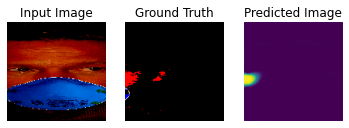

2 epoch:   0%|                              | 0/806 [00:41<?, ?it/s, loss=0.426]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


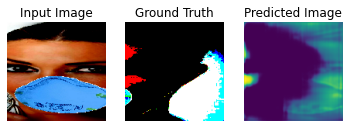

3 epoch:   0%|                              | 0/806 [00:58<?, ?it/s, loss=0.499]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


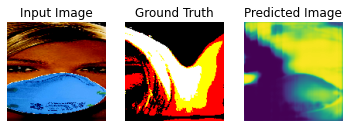

3 epoch: 100%|████████████████████| 806/806 [04:43<00:00,  2.84it/s, loss=0.445]


In [ ]:
mask_G= Mask_G(filters=32)
mask_train = Train_Mask(mask_G,checkpoint_dir =mask_checkpoint_dir)
mask_train.fit(trainset, epochs=3)

In [ ]:
mask_G.save('/content/drive/MyDrive/SJSU assignment Docs/Spring 22/Face Mask project/GAN-based-face-mask-removal-version2-forked/Trained Model/MaskG')

Face Train

In [ ]:
face_G, face_D_whole, face_D_region, vgg19 =  Face_G(filters=64), Face_D_whole(filters=64), Face_D_region(filters=64), VGG19_model()
face_train = Train_Face(mask_G, face_G, face_D_whole, face_D_region, vgg19,
                                mask_checkpoint_dir=mask_checkpoint_dir, face_checkpoint_dir=face_checkpoint_dir, dis_checkpoint_dir=dis_checkpoint_dir)
face_train.fit(trainset, epochs=5)

In [ ]:
face_G.save('/content/drive/MyDrive/SJSU assignment Docs/Spring 22/Face Mask project/GAN-based-face-mask-removal-version2-forked/Trained Model/FaceG')
face_D_whole.save('/content/drive/MyDrive/SJSU assignment Docs/Spring 22/Face Mask project/GAN-based-face-mask-removal-version2-forked/Trained Model/face_D_whole')
face_D_region.save('/content/drive/MyDrive/SJSU assignment Docs/Spring 22/Face Mask project/GAN-based-face-mask-removal-version2-forked/Trained Model/face_D_region')
#vgg19.save('/content/drive/MyDrive/SJSU assignment Docs/Spring 22/Face Mask project/GAN-based-face-mask-removal-version2-forked/Trained Model/vgg19')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/SJSU assignment Docs/Spring 22/Face Mask project/GAN-based-face-mask-removal-version2-forked/Trained Model/FaceG/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/SJSU assignment Docs/Spring 22/Face Mask project/GAN-based-face-mask-removal-version2-forked/Trained Model/face_D_whole/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/SJSU assignment Docs/Spring 22/Face Mask project/GAN-based-face-mask-removal-version2-forked/Trained Model/face_D_region/assets


Single Image testing

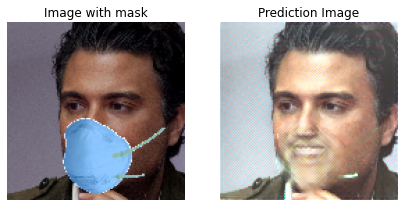

In [ ]:
mask_G, face_G = Mask_G(filters=32), Face_G(filters=64)
test = Load_model(mask_G, face_G, mask_checkpoint_dir="/content/drive/MyDrive/SJSU assignment Docs/Spring 22/Face Mask project/GAN-based-face-mask-removal-version2-forked/mask32_checkpoints", face_checkpoint_dir="/content/drive/MyDrive/SJSU assignment Docs/Spring 22/Face Mask project/GAN-based-face-mask-removal-version2-forked/face_checkpoints")
test.load()
img = test.one_predict("/content/drive/MyDrive/SJSU assignment Docs/Spring 22/Face Mask project/Dataset/Test_masked/1051_N95.jpg")

In [ ]:
img.save("/content/drive/MyDrive/SJSU assignment Docs/Spring 22/Face Mask project/GAN-based-face-mask-removal-version2-forked/Pred/pred.jpg")

Multiple Image testing

In [ ]:
mask_G, face_G = Mask_G(filters=32), Face_G(filters=64)
test = Load_model(mask_G, face_G, mask_checkpoint_dir=mask_checkpoint_dir, face_checkpoint_dir=face_checkpoint_dir)
test.load()
test.multiple_predict(test_path)

Training set